# _QECC:_ Shor's 9-qubit algorithm

In the following cells we would perform the Shor's 9-qubit algorithm, a quantum error correction circuit which can diagnose and repair one bit and/or phase-flip error in a 9-qubit circuit, based on the concatenation of 3-qubit bit and phase-flip QECC.

As every unitary error applied to a state can be described as a linear combination of the *Pauli group matrices*, i.e. $\{I, \sigma_i\}$, we can correct our errors using $X$ and $Z$-gates. See that $Y = iXZ$, so a $Y$-error can be expressed as a concatenation of $X$ and $Z$-errors plus a $\pi/2$ complex global phase.

---

**Author: Sebastián V. Romero** ([sebastian.vidal@rai.usc.es](mailto:sebastian.vidal@rai.usc.es))

*Last update:* 4th April 2021

## Package and function imports

In [1]:
%run QECC_Shor9Q_functions.ipynb

## Let's draw the circuit!

### Initialization

We start registering our 9 qubits and 8 ancillas for the error correction. Also, we initialize our entangled initial vector state $|\phi\rangle = a |0\rangle + b |1\rangle$, defining the constants and normalizing the created state.

In [2]:
# Qubits for our entangled state
q0 = QuantumRegister(3, name = 'q0')
q1 = QuantumRegister(3, name = 'q1')
q2 = QuantumRegister(3, name = 'q2')

# Ancillas for bit-flip errors
bf0 = AncillaRegister(2, name = 'bf0')
bf1 = AncillaRegister(2, name = 'bf1')
bf2 = AncillaRegister(2, name = 'bf2')

# Ancillas for phase-flip errors
pf = AncillaRegister(2, name = 'pf')

circuit = QuantumCircuit(q0, bf0, q1, bf1, q2, bf2, pf)

# Define our initial normalized state
initial_state = normalize_state(1.0 + 1.0j, 2.0 + 0.0j)
circuit.initialize(initial_state, 0)

# Draws the circuit
# circuit.draw(output = 'mpl', plot_barriers = False)

### Obtain the initial 9-qubit state

As a first part, we add a $CNOTNOT$ in qubits 0, 3 and 6 in order to extend our *physical basis* $\{ |0\rangle, |1\rangle \}$ to the *logical basis* spanning the *codespace* $\mathcal{C} = \mathrm{span}\{ |0\rangle_L = |000\rangle, |1\rangle_L = |111\rangle \}$. Explicitly,

\begin{equation}
|\phi\rangle = a|0\rangle + b|1\rangle \rightarrow |\phi\rangle_L = a|000\rangle + b|111\rangle.
\end{equation}

Then, we add in the same qubits three Hadamard gates to go from $\{ |0\rangle_L, |1\rangle_L \}$ basis to $\{ |+\rangle_L = |+\rangle|+\rangle|+\rangle, |-\rangle_L = |-\rangle|-\rangle|-\rangle \}$, being $|\pm\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle \pm |1\rangle \right)$, the $\sigma_x$ basis. It's more convenient to use this basis since $X |\pm\rangle = \pm |\pm\rangle$ ($X$ acts like a diagonal matrix in its own basis) and $Z |\pm\rangle = |\mp\rangle$ (bit-flip operation). Then, we have as final state of this part

\begin{equation}
\begin{aligned}
|\psi\rangle = &\frac{a}{2\sqrt{2}} (|000\rangle + |111\rangle) \otimes (|000\rangle + |111\rangle) \otimes (|000\rangle + |111\rangle) \\
+&\frac{b}{2\sqrt{2}} (|000\rangle - |111\rangle) \otimes (|000\rangle - |111\rangle) \otimes (|000\rangle - |111\rangle) \\
= & a |{+++}\rangle \otimes |{+++}\rangle \otimes |{+++}\rangle + b |{---}\rangle \otimes |{---}\rangle \otimes |{---}\rangle.
\end{aligned}
\end{equation}

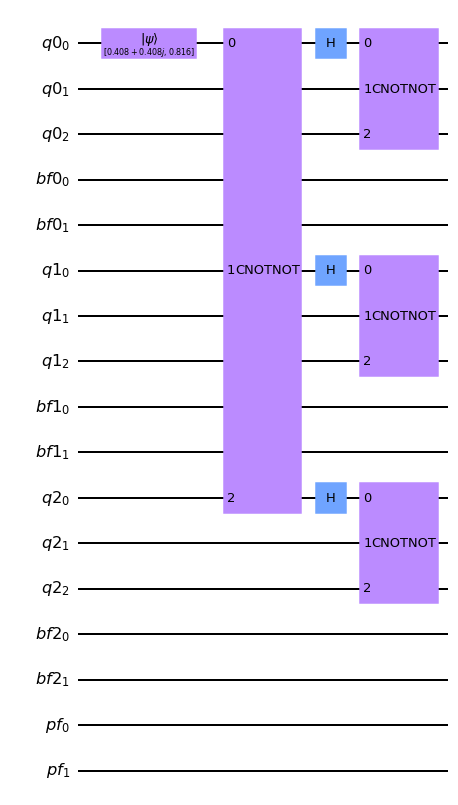

In [3]:
# Add controlled-NOTNOT to qubits 0, 3 and 6
circuit.append(cnotnot(), [q0[0], q1[0], q2[0]])

# Add Hadamard gates to qubits 0, 3 and 6
circuit.h(q0[0])
circuit.h(q1[0])
circuit.h(q2[0])

# Add controlled-NOTNOT in our three packs of three qubits
circuit.append(cnotnot(), [q0[0], q0[1], q0[2]])
circuit.append(cnotnot(), [q1[0], q1[1], q1[2]])
circuit.append(cnotnot(), [q2[0], q2[1], q2[2]])

circuit.barrier(q0, bf0, q1, bf1, q2, bf2, pf)

circuit.draw(output = 'mpl', plot_barriers = False)

In [4]:
_ = get_state(circuit, fancy_print = True)

(0.4330127019+0.1443375673j) |00000000000000000>   (-0.1443375673+0.1443375673j) |11100000000000000>   (-0.1443375673+0.1443375673j) |00000111000000000>   (0.4330127019+0.1443375673j) |11100111000000000>   (-0.1443375673+0.1443375673j) |00000000001110000>   (0.4330127019+0.1443375673j) |11100000001110000>   (0.4330127019+0.1443375673j) |00000111001110000>   (-0.1443375673+0.1443375673j) |11100111001110000>   


### Add some noise to our circuit


We add a random noise gate in order to apply some errors to the $|\psi\rangle$ state.

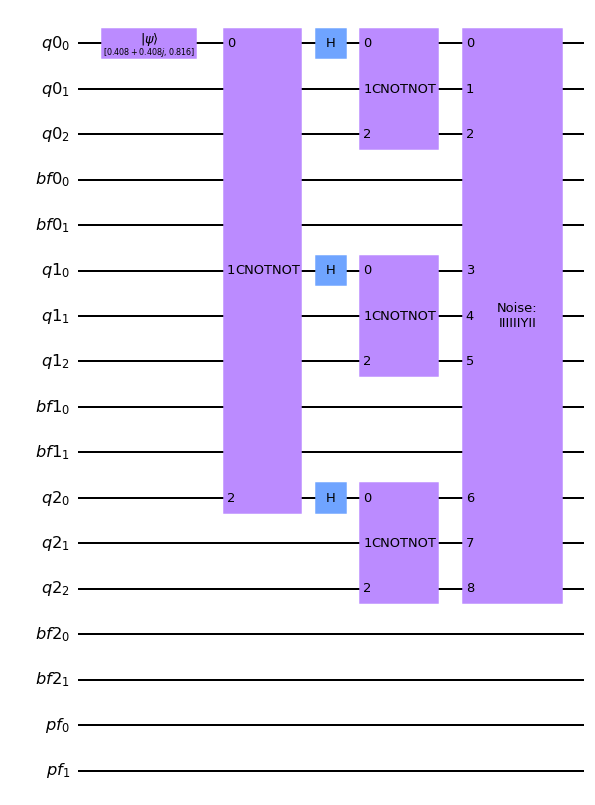

In [5]:
# Add a source of random noise in our channels
circuit.append(random_noise(reveal_error = True), 
                            [q0[0], q0[1], q0[2],
                             q1[0], q1[1], q1[2],
                             q2[0], q2[1], q2[2]])

circuit.barrier(q0, bf0, q1, bf1, q2, bf2, pf)

circuit.draw(output = 'mpl', plot_barriers = False)

In [6]:
_ = get_state(circuit, fancy_print = True)

(-0.1443375673+0.4330127019j) |00000000001000000>   (-0.1443375673-0.1443375673j) |11100000001000000>   (-0.1443375673-0.1443375673j) |00000111001000000>   (-0.1443375673+0.4330127019j) |11100111001000000>   (0.1443375673+0.1443375673j) |00000000000110000>   (0.1443375673-0.4330127019j) |11100000000110000>   (0.1443375673-0.4330127019j) |00000111000110000>   (0.1443375673+0.1443375673j) |11100111000110000>   


### Bit-flip error correction

The two initial Hadamard gates $H$ let change $|0\rangle \rightarrow |+\rangle$, having our controlls in the ancillas and the *syndrome detectors* in our qubit channels. We reverse that with another two Hadamard gates. It's important to see the different ancillas states possibilities, as we summarize in the next table for the first pack of three qubits (it's just the same for the another two packs). The subindices denote in which qubit of the pack the error is applied.

| Error | Syndrome | Ancilla | $$Z_0 Z_1$$ | $$Z_1 Z_2$$ |
| :-: | :-: | :-: | :-: | :-: |
| $$I$$   | $$a |000\rangle + b |111\rangle$$ | $$|00\rangle$$ | + | + |
| $$X_0$$ | $$a |100\rangle + b |011\rangle$$ | $$|10\rangle$$ | - | + |
| $$X_1$$ | $$a |010\rangle + b |101\rangle$$ | $$|11\rangle$$ | - | - |
| $$X_2$$ | $$a |001\rangle + b |110\rangle$$ | $$|01\rangle$$ | + | - |

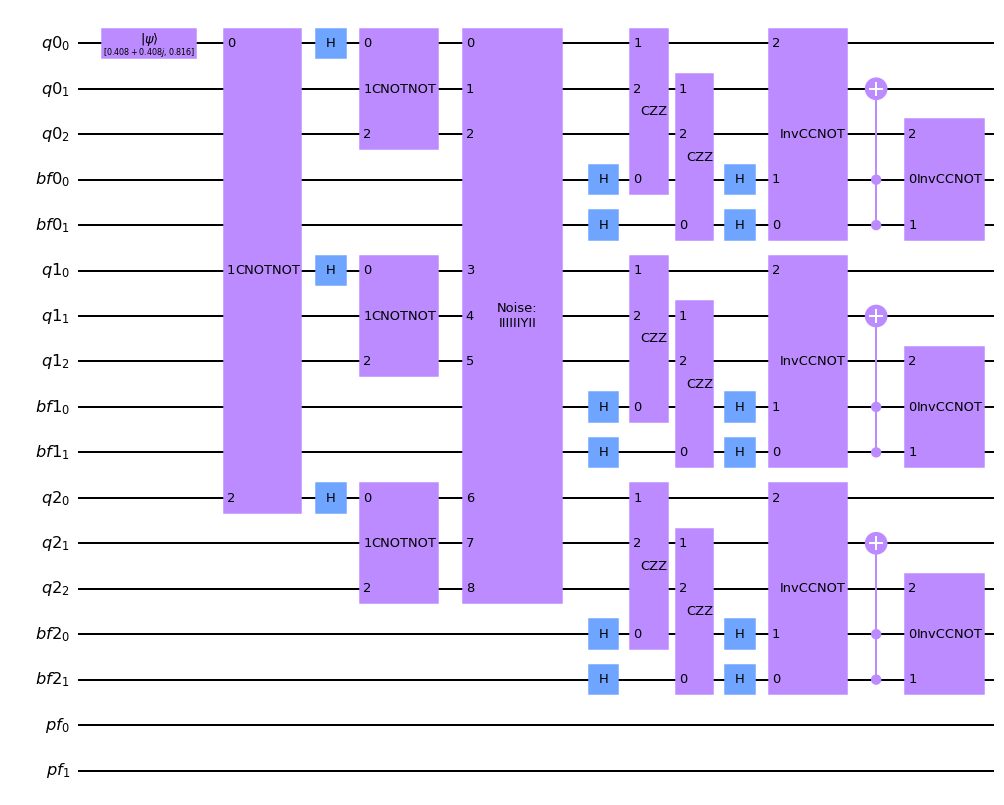

In [7]:
# Add Hadamard gates for the bit-flip ancillas
for index in range(2):
    circuit.h(bf0[index])
    circuit.h(bf1[index])
    circuit.h(bf2[index])

# Add controlled-ZZ gates in our ancillas
# First pack of three qubits
circuit.append(czz(), [bf0[0], q0[0], q0[1]])
circuit.append(czz(), [bf0[1], q0[1], q0[2]])

# Second pack of three qubits
circuit.append(czz(), [bf1[0], q1[0], q1[1]])
circuit.append(czz(), [bf1[1], q1[1], q1[2]])

# Third pack of three qubits
circuit.append(czz(), [bf2[0], q2[0], q2[1]])
circuit.append(czz(), [bf2[1], q2[1], q2[2]])

circuit.barrier(q0, bf0, q1, bf1, q2, bf2, pf)

# Add Hadamard gates for the bit-flip ancillas
for index in range(2):
    circuit.h(bf0[index])
    circuit.h(bf1[index])
    circuit.h(bf2[index])

# Add double controlled gates to correct bit-flip errors
# First pack of three qubits
circuit.append(invccnot(), [bf0[1], bf0[0], q0[0]])
circuit.ccx(bf0[0], bf0[1], q0[1])
circuit.append(invccnot(), [bf0[0], bf0[1], q0[2]])

# Second pack of three qubits
circuit.append(invccnot(), [bf1[1], bf1[0], q1[0]])
circuit.ccx(bf1[0], bf1[1], q1[1])
circuit.append(invccnot(), [bf1[0], bf1[1], q1[2]])

# Third pack of three qubits
circuit.append(invccnot(), [bf2[1], bf2[0], q2[0]])
circuit.ccx(bf2[0], bf2[1], q2[1])
circuit.append(invccnot(), [bf2[0], bf2[1], q2[2]])

circuit.barrier(q0, bf0, q1, bf1, q2, bf2, pf)


# BIT-FLIP ERRORS SOLVED! Let's go with the phase-flip errors

circuit.draw(output = 'mpl', plot_barriers = False)

In [8]:
_ = get_state(circuit, fancy_print = True)

(-0.1443375673+0.4330127019j) |00000000000001000>   (-0.1443375673-0.1443375673j) |11100000000001000>   (-0.1443375673-0.1443375673j) |00000111000001000>   (-0.1443375673+0.4330127019j) |11100111000001000>   (0.1443375673+0.1443375673j) |00000000001111000>   (0.1443375673-0.4330127019j) |11100000001111000>   (0.1443375673-0.4330127019j) |00000111001111000>   (0.1443375673+0.1443375673j) |11100111001111000>   


### Phase-flip error correction

The idea is pretty similar to the bit-flip error correction part. The two initial Hadamard gates $H$ let change $|0\rangle \rightarrow |+\rangle$, having our controlls in the ancillas and the *syndrome detectors* in our qubit channels. We reverse that with another two Hadamard gates. It's important to see the different ancillas states possibilities, as we summarize in the next table for the three packs of qubits. Now, the subindices are used to denote in which pack of qubits the phase-flip error is applied.

| Error | Syndrome | Ancilla | $$X_0 X_1 X_2 X_3 X_4 X_5$$ | $$X_3 X_4 X_5 X_6 X_7 X_8$$ |
| :-: | :-: | :-: | :-: | :-: |
| $$I$$              | $$a |000\rangle + b |111\rangle$$ | $$|00\rangle$$ | + | + |
| $$Z_\mathrm{1st}$$ | $$a |100\rangle + b |011\rangle$$ | $$|10\rangle$$ | - | + |
| $$Z_\mathrm{2nd}$$ | $$a |010\rangle + b |101\rangle$$ | $$|11\rangle$$ | - | - |
| $$Z_\mathrm{3rd}$$ | $$a |001\rangle + b |110\rangle$$ | $$|01\rangle$$ | + | - |

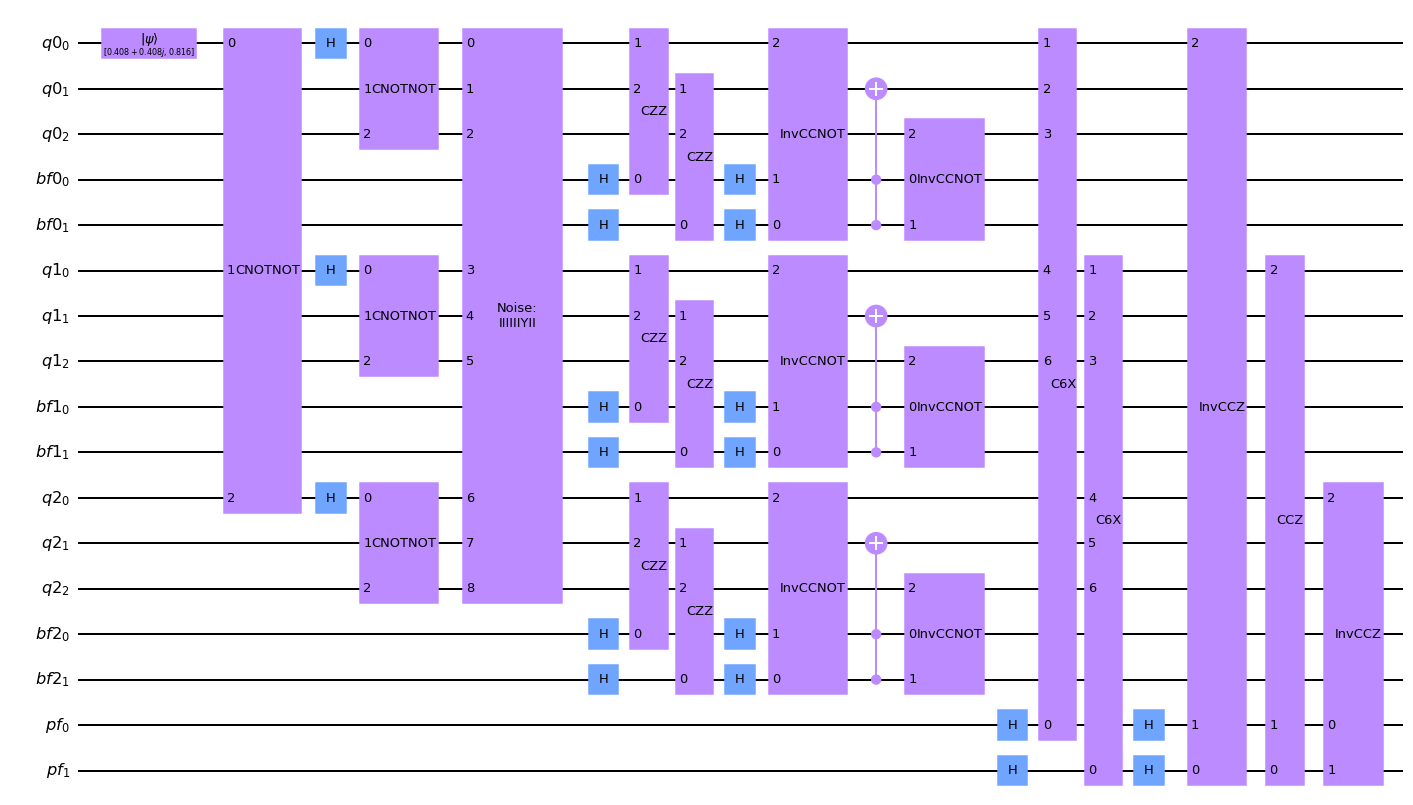

In [9]:
# Add Hadamard gates for the phase-flip ancillas
for index in range(2):
    circuit.h(pf[index])

# Add controlled-6X gates in our ancillas
circuit.append(c6x(), [pf[0], q0[0], q0[1], q0[2], q1[0], q1[1], q1[2]])
circuit.append(c6x(), [pf[1], q1[0], q1[1], q1[2], q2[0], q2[1], q2[2]])

# Add Hadamard gates for the phase-flip ancillas
for index in range(2):
    circuit.h(pf[index])

# Add double controlled gates to correct phase-flip errors
circuit.append(invccz(), [pf[1], pf[0], q0[0]])
circuit.append(ccz(), [pf[1], pf[0], q1[0]])
circuit.append(invccz(), [pf[0], pf[1], q2[0]])

circuit.barrier(q0, bf0, q1, bf1, q2, bf2, pf)


# PHASE-FLIP ERRORS SOLVED! Let's go for the final manipulations in our state

circuit.draw(output = 'mpl', plot_barriers = False, fold = 40)

In [10]:
_ = get_state(circuit, fancy_print = True)

(-0.1443375673+0.4330127019j) |00000000000001001>   (-0.1443375673-0.1443375673j) |11100000000001001>   (-0.1443375673-0.1443375673j) |00000111000001001>   (-0.1443375673+0.4330127019j) |11100111000001001>   (-0.1443375673-0.1443375673j) |00000000001111001>   (-0.1443375673+0.4330127019j) |11100000001111001>   (-0.1443375673+0.4330127019j) |00000111001111001>   (-0.1443375673-0.1443375673j) |11100111001111001>   


### Let's get our corrected final state!

We "reverse" the steps that we did in our first block of gates, where we prepare our $|\psi\rangle$ state.

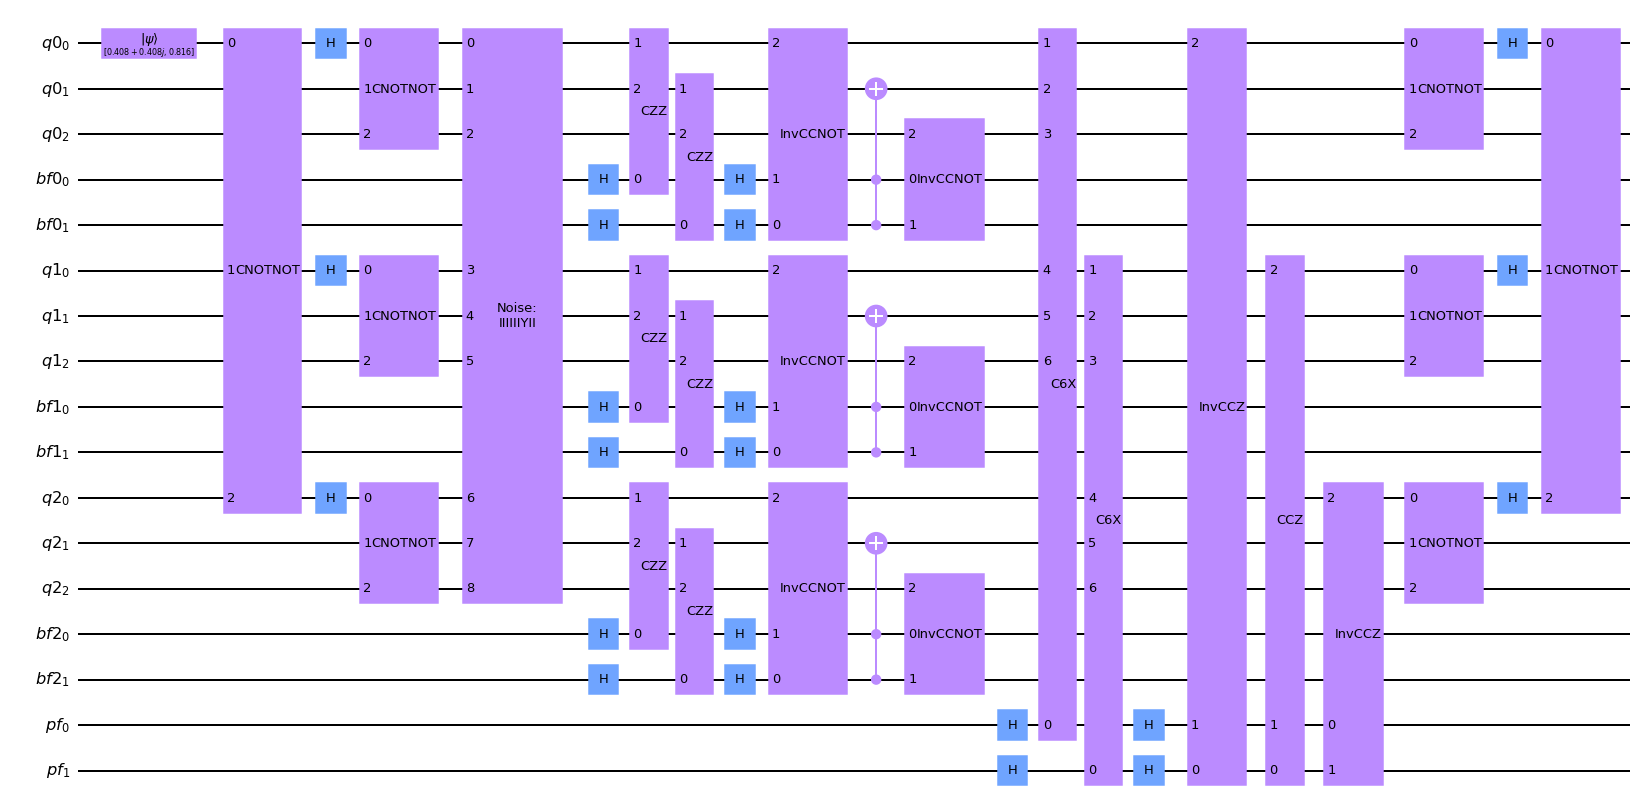

In [11]:
# Add controlled-NOTNOT in our three packs of three qubits
circuit.append(cnotnot(), [q0[0], q0[1], q0[2]])
circuit.append(cnotnot(), [q1[0], q1[1], q1[2]])
circuit.append(cnotnot(), [q2[0], q2[1], q2[2]])

# Add Hadamard gates to qubits 0, 3 and 6
circuit.h(q0[0])
circuit.h(q1[0])
circuit.h(q2[0])

# Add controlled-NOTNOT to qubits 0, 3 and 6
circuit.append(cnotnot(), [q0[0], q1[0], q2[0]])

circuit.draw(output = 'mpl', plot_barriers = False, fold = 40)

### Get the state

In [12]:
# Get the state vector
final_state = get_state(circuit, fancy_print = True)

(-0.4082482905+0.4082482905j) |00000000000001001>   0.8164965809j |10000000000001001>   


We can check if our expected ancillas correspond to our *final_state* ancillas

In [13]:
check_error_to_ancilla(final_state)

Error  Anc. expected  Anc. state  Equal?
----------------------------------------
 X0     00             00          True
 X1     00             00          True
 X2     10             10          True
 Z      01             01          True


### Latex code of the circuit

Prints and saves the latex source to a file. Uncomment the following line of code if you want to use it.

In [14]:
# print(circuit.draw(output = 'latex_source', filename = '/tmp/circuit.tex'))

## Version information

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table